In [23]:

import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import kurtosis

# Autor: Mustapha Bousakla
# MODULO PARA SIMULACIONES
# Nomenclatura:
#   PO: Parámetro de Orden (Order Parameter)
#   t: tiempo (time)
#   X: variable que evoluciona con el tiempo y tiene como parámetro PO. (variable X[t,PO])

def ReadParameters(InFile,N,v0,rho,MidoCada,printing):
    with open(InFile) as f_in_names:
    
        plots=csv.reader(f_in_names,delimiter = ' ')
        Naux=int(f_in_names.readline().split()[1])
        N.append(Naux)
        L=int(f_in_names.readline().split()[1])
        v0.append(float(f_in_names.readline().split()[1]))
        for i in range(5):
            next(plots)
        MidoCada.append(int(f_in_names.readline().split()[1]))
        rho.append(Naux/L**2)
        if printing == True:
            print('N = %s' % N)
            print('rho = %s' % rho)
            print( r'$\Delta$ t = %s' % MidoCada)
    
    return 
# función para leer las tablas .dat


def Autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]


#creamos una rutina que calcula el tiempo de equilibración
#distingue si es mayor a un dado límite o no
def ExtractTauEq(noise,f_fit,time,ACT,lowerBound):
    TauEq=[]
    for j in range(len(noise)):
        tau_temp=curve_fit(f_fit,time,ACT[j], maxfev = 50000)[0][0]
        if tau_temp <= lowerBound:
            TauEq.append(lowerBound)
        else:
            TauEq.append(tau_temp)
        
    return TauEq


""" La función Graficador """
# -------------- ACLARACIONES --------------
# el parámetro 'grafico' es una lista cuyos elementos
# contienen la siguiente información, en el siguiente orden:
# grafico[0]=[x,y,yerr,fmt,label]
# x: variable indepentiente
# y: variable dependiente
# yerr: error de variable dependiente
# fmt: formato, es de tipo string
# label: etiquieta, tipo string
#-------------- EJEMPLO -------------
#grafico=[[graf1][graf2][graf3]]
#graf1=[x,y,yEr,'g-',label]
#----------------------------
def Graficador(grafico,xlabel,ylabel,title):
# =============================================================================
#     print("grafico=[[graf1][graf2][graf3]]")
#     print("graf1=[x,y,yEr,'g-',label]")
# =============================================================================
    assert type(grafico[0])==list, 'missing brakets in "grafico" '
    for item in grafico:
        plt.errorbar(
                item[0],
                item[1],
                yerr = item[2],
                fmt=item[3],
                ecolor='k',
                label = item[4] )
    
    plt.xlabel(xlabel,fontsize = 20)
    plt.ylabel(ylabel,fontsize = 20)
    plt.title(title)
    plt.legend()
    plt.show()
    return
""" END función Graficador """


class AnalysisVicsek(object):
    
    
    def __init__(self,runNbr,inFiles,typeAnalysis,parameters):
        self.runNbr = runNbr
        self.inFiles = inFiles
        assert len(inFiles)==3, 'Must privide a 3 length list'
        self.typeAnalysis = typeAnalysis
        self.parameters = parameters
        self.M_Period = parameters[3] #period of messurements
#        self.tauEq = 0

        return


    #from inFiles read Parameters and Variables

    def getVariables(self, fileToRead):
        with open(fileToRead, 'r') as archivo:
            noise=np.asarray(archivo.readline().split()[1::],float)
            lines=archivo.readlines()
            result=[]
            for x in lines:
                result.append(x.split( )[0])
    
            result2=[float(result[i]) for i in range(1,len(result))]
            time=np.asarray(result2, float)
            lines2=[lines[i] for i in range(1, len(result2)+1)]
            X3=[]
            for i in range(1,len(noise)+1):
                X2=[]
                for x in lines2:
                    X2.append(x.split( )[i])
                X3.append(X2)
        
            X=np.asarray(X3,float)
    
        return noise, time, X  
   
    # Set noise
    @property
    def vicsekNoise(self):
        return self.getVariables(self.inFiles[1])[0]
    
    def _calc_acorr(self,tEq):
        print('tEq is a presumed time of equilibration different than tauEq')
        first=int(tEq/self.M_Period)
        Acorr=[]
        OP=self.get_OrderParam
        for k in range(len(self.vicsekNoise)):
            # estimate Acorr from an stabilized array
            Acorr.append(Autocorr(OP[k][first::]))
    
        return np.array(Acorr,float)
    
    @property
    def acorrTime(self,t_f=200):
        # we save only up to len(OP)/2 because after that we have little
        # amount of points to estimate Acorr with few error.
#        t_f=250
        time=self.getVariables(self.inFiles[0])[1][:t_f]

        return np.asarray(time,float)
    
    @property
    def acorr(self):
        Acorr = self.getVariables(self.inFiles[0])[2][:,:200]
        return np.asarray(Acorr,float)
    
    
    #Now we need to extract the equilibrium time 'tauEq'.
    def get_tauEq(self,FittingFunction):
        #check dimensions
        #check the way the function is defined
        print('CAREFUL: FittingFunction must be like F(x,tau,A,y0,**p)')
        #falta proteger la variable tauEq
        tauEq=ExtractTauEq(
                self.vicsekNoise,
                FittingFunction,
                self.acorrTime,
                self.acorr,
                self.M_Period
                )
#        self.tauEq = np.array(tauEq,float)
        print(tauEq)
        return np.array(tauEq,float)
    

    #get order parameter time array
    @property
    def get_OPtime(self):    
        return self.getVariables(self.inFiles[1])[1]
    #get order parameter array
    @property
    def get_OrderParam(self):
        return self.getVariables(self.inFiles[1])[2]
    
    
    # calculate the mean,var and kurtosis of the variable X from an initial time tauEq
    def _calc_X_Stats(self,X,tauEq):   
        X_mean=[]
        X_var=[]
        X_kurt=[]
        for k in range(len(self.vicsekNoise)):
            aux_t=self.M_Period
            tauEq[k]/=aux_t
            # tauEq[k]/=self.M_Period
            X_mean.append(np.mean(X[k][int(tauEq[k]):]))
            X_var.append(np.var(X[k][int(tauEq[k]):]))
            X_kurt.append(kurtosis(X[k][int(tauEq[k]):],fisher=True))
            # tauEq[k]*=self.M_Period #idk how to avoid de method to change the original value.. so re calc
        X_mean=np.asarray(X_mean,float)
        X_var=np.asarray(X_var,float)
        X_kurt=np.asarray(X_kurt,float)
        return X_mean,X_var,X_kurt
       
    def get_OP_Mean(self,tauEq):
        OPMean = self._calc_X_Stats(self.get_OrderParam,tauEq)[0]
        return OPMean
    
    def get_OP_Var(self,tauEq):
        OPVar = self._calc_X_Stats(self.get_OrderParam,tauEq)[1]
        return OPVar
    
    """ CumulanteBinder = CB_A = 1- <Phi^4>/3*<Phi^2>^2"""
    def _calc_X_BinderCumulant(self,tauEq):
        BindCum = 1 -self._calc_X_Stats(self.get_OrderParam,tauEq)[2]/3
        return BindCum
    

    def ErrOP(self,tauEq):
        errOP=[]
        for k in range(len(self.vicsekNoise)):
            if tauEq[k]<=self.M_Period:
                n=len(self.get_OPtime)
                errOP.append(np.sqrt(self.get_OP_Var(tauEq)[k]/(n-1)))
            else:
                tmax=max(self.get_OPtime) - tauEq[k]
                n=2*tauEq[k]/tmax
                errOP.append(np.sqrt(n*self.get_OP_Var(tauEq)[k]))
    #            errOP = np.sqrt(self.get_OP_Var/(n-1))
        
        return np.array(errOP,float)
"""END OF CLASS AnalysisVicsek"""
print('fet')

fet


In [24]:
import sys
sys.path.insert(0,'C:/Users/musta')
import numpy as np
import math
import matplotlib.pyplot as plt


print('fets imports')

fets imports


In [51]:

nroFilesV=0


VecInFiles=[]
InFile=[]

G=0
decG = math.modf(G)[0]
for j in range(10,15):
    namearch  = 'Entrada_Parametros_Vicsek'+str(j)+'.dat'
    acorrFile='ACorr_VV'+str(j)+'_G'+str(int(G))+'p'+str(int(decG*10))+'.dat'
    PhiFile='CrudosVicsekV'+str(j)+'_G'+str(int(G))+'p'+str(int(decG*10))+'.dat'
    PhiSqrFile='CrudosVicsekvV'+str(j)+'_G'+str(int(G))+'p'+str(int(decG*10))+'.dat'
    VecInFiles.append([acorrFile,PhiFile,PhiSqrFile])
    InFile.append(namearch)
    nroFilesV+=1
    
print(VecInFiles)

[['ACorr_VV10_G0p0.dat', 'CrudosVicsekV10_G0p0.dat', 'CrudosVicsekvV10_G0p0.dat'], ['ACorr_VV11_G0p0.dat', 'CrudosVicsekV11_G0p0.dat', 'CrudosVicsekvV11_G0p0.dat'], ['ACorr_VV12_G0p0.dat', 'CrudosVicsekV12_G0p0.dat', 'CrudosVicsekvV12_G0p0.dat'], ['ACorr_VV13_G0p0.dat', 'CrudosVicsekV13_G0p0.dat', 'CrudosVicsekvV13_G0p0.dat'], ['ACorr_VV14_G0p0.dat', 'CrudosVicsekV14_G0p0.dat', 'CrudosVicsekvV14_G0p0.dat']]


In [52]:
import sys
sys.path.insert(0,'C:/Users/musta')
import numpy as np
import math
import matplotlib.pyplot as plt


print('fets imports')

fets imports


In [53]:
N=[]
v0=[]
rho=[]
MidoCada=[]

parameters=[]
for j in range(nroFilesV):
    ReadParameters(InFile[j],N,v0,rho,MidoCada,True)    
    parameters.append([N[j],v0[j],rho[j],MidoCada[j]])
    
print(parameters)

N = [225]
rho = [1.0]
$\Delta$ t = [100]
N = [225, 196]
rho = [1.0, 1.0]
$\Delta$ t = [100, 100]
N = [225, 196, 144]
rho = [1.0, 1.0, 1.0]
$\Delta$ t = [100, 100, 100]
N = [225, 196, 144, 100]
rho = [1.0, 1.0, 1.0, 1.0]
$\Delta$ t = [100, 100, 100, 100]
N = [225, 196, 144, 100, 64]
rho = [1.0, 1.0, 1.0, 1.0, 1.0]
$\Delta$ t = [100, 100, 100, 100, 100]
[[225, 1.25, 1.0, 100], [196, 1.25, 1.0, 100], [144, 1.25, 1.0, 100], [100, 1.25, 1.0, 100], [64, 1.25, 1.0, 100]]


In [54]:

VV_OBJ=[]
parametersV=[parameters[k] for k in range(0,len(parameters),2)]
for j in range(nroFilesV):
    VV_OBJ.append(AnalysisVicsek(j,
                                     VecInFiles[j],
                                     'V',
                                     parameters[j]))


print(VecInFiles,VV_OBJ[0])

[['ACorr_VV10_G0p0.dat', 'CrudosVicsekV10_G0p0.dat', 'CrudosVicsekvV10_G0p0.dat'], ['ACorr_VV11_G0p0.dat', 'CrudosVicsekV11_G0p0.dat', 'CrudosVicsekvV11_G0p0.dat'], ['ACorr_VV12_G0p0.dat', 'CrudosVicsekV12_G0p0.dat', 'CrudosVicsekvV12_G0p0.dat'], ['ACorr_VV13_G0p0.dat', 'CrudosVicsekV13_G0p0.dat', 'CrudosVicsekvV13_G0p0.dat'], ['ACorr_VV14_G0p0.dat', 'CrudosVicsekV14_G0p0.dat', 'CrudosVicsekvV14_G0p0.dat']] <__main__.AnalysisVicsek object at 0x000001F1AC746160>


In [55]:
eta=VV_OBJ[0].vicsekNoise
print(eta)

[0.1  0.14 0.18 0.21 0.25 0.29 0.33 0.37 0.4  0.44 0.48 0.52 0.56 0.6
 0.63 0.67 0.71 0.75 0.79 0.82 0.86 0.9 ]


In [56]:
tACTVEC=[]
ACTVEC=[]
for j in range(nroFilesV):
    tACTVEC.append(VV_OBJ[j].acorrTime)
    ACTVEC.append(VV_OBJ[j].acorr)
    
print('fet')

fet


In [31]:
'Vectorial - $N = %s$, $\rho = %s$'%(N[k],rho[k]'

SyntaxError: EOL while scanning string literal (Temp/ipykernel_15244/789996204.py, line 1)

In [32]:
print(nroFilesV)

5


In [57]:
labels = [r'$\eta = %s$' % eta[j] for j in range(len(eta))]
formatACT=['k.-','r.-','m.-','c.-','b.-','g.-','y.-','gv-','kv-','rv-']

graficoACT_V=[]
for k in range(nroFilesV):
    tituloAcorr=r'Vectorial - $N = %s$, $\rho = %s$' %(N[k],rho[k])
    graficoACT_V.append(
            [[tACTVEC[k],ACTVEC[k][j],None,formatACT[j],labels[j]]
            for j in range(0,len(eta),3)]
            )
    plt.figure(k)
    Graficador(graficoACT_V[k],'$t [MCS]$','$Acorr$',tituloAcorr)

IndexError: list index out of range

In [58]:
def f(x,tau,b,y0): 
    return b*np.exp(-x/tau) + y0


In [59]:
initGuessV=[[[MidoCada[k],ACTVEC[k][j][0],0] for j in range(len(eta))]for k in range(nroFilesV)]#semilla para el ajuste  
# obtener el tiempo de eq. para cada curva de ACT
tauEq_V=[VV_OBJ[k].get_tauEq(f) for k in range(nroFilesV)]

CAREFUL: FittingFunction must be like F(x,tau,A,y0,**p)


C:\Users\musta\Anaconda2\envs\python3.8\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
CAREFUL: FittingFunction must be like F(x,tau,A,y0,**p)
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
CAREFUL: FittingFunction must be like F(x,tau,A,y0,**p)
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
CAREFUL: FittingFunction must be like F(x,tau,A,y0,**p)
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
CAREFUL: FittingFunction must be like F(x,tau,A,y0,**p)
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


In [60]:
print(len(eta))

22


In [61]:
VA_OBJ[0].get_OrderParam

NameError: name 'VA_OBJ' is not defined

In [62]:
PhiMean_V=[VV_OBJ[k].get_OP_Mean(tauEq_V[k]) for k in range(nroFilesV)]
PhiVar_V=[VV_OBJ[k].get_OP_Var(tauEq_V[k]) for k in range(nroFilesV)]
PhiCB_V=[VV_OBJ[k]._calc_X_BinderCumulant(tauEq_V[k]) for k in range(nroFilesV)]

print(PhiMean_V)

[array([0.79140651, 0.78395928, 0.77530078, 0.76524429, 0.75259237,
       0.7388958 , 0.72000149, 0.69884644, 0.67037444, 0.6226646 ,
       0.28089445, 0.09788061, 0.08553615, 0.07228671, 0.06444941,
       0.06265571, 0.05322863, 0.05811379, 0.05417174, 0.05199463,
       0.04988853, 0.0544535 ]), array([0.7912831 , 0.78467099, 0.77575149, 0.76576176, 0.75365056,
       0.73904796, 0.72265862, 0.69920755, 0.67170593, 0.62133447,
       0.28768908, 0.11392303, 0.0793441 , 0.07814964, 0.06924259,
       0.06692816, 0.06246816, 0.0561695 , 0.05811461, 0.05882966,
       0.05475617, 0.05516201]), array([0.79166529, 0.78467048, 0.77641104, 0.76611061, 0.75506783,
       0.7394636 , 0.72212555, 0.70199544, 0.67433149, 0.62640212,
       0.31135982, 0.12993516, 0.09918311, 0.0928507 , 0.07966854,
       0.0691004 , 0.06689528, 0.06853081, 0.06976324, 0.06589973,
       0.06364557, 0.06495985]), array([0.79214893, 0.78549784, 0.77775996, 0.7673067 , 0.75569658,
       0.74167206, 0.72473595

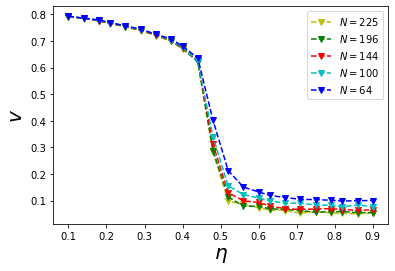

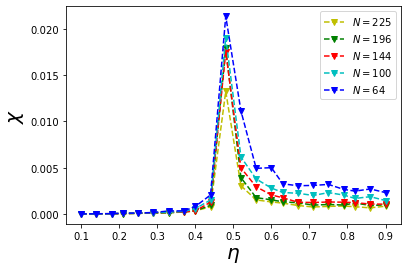

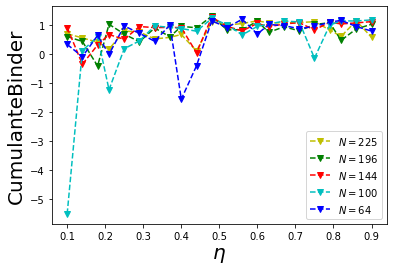

In [63]:
StatsLabels_V=[r'$N=%s$'%N[k] for k in range(nroFilesV)]
formatosV=['yv--','gv--','rv--','cv--','bv--']

graficoOP_V=[[eta,PhiMean_V[k],None,formatosV[k],StatsLabels_V[k]] for k in range(nroFilesV)]
graficoSuc_V=[[eta,PhiVar_V[k],None,formatosV[k],StatsLabels_V[k]]for k in range(nroFilesV)]
graficosCB_V=[[eta[:],PhiCB_V[k][:],None,formatosV[k],StatsLabels_V[k]]for k in range(nroFilesV)]

plt.figure(9)
Graficador(graficoOP_V,r'$\eta$',r'$v$','')
plt.figure(12)
Graficador(graficoSuc_V,'$\eta$',r'$\chi$','')
plt.figure(13)
Graficador(graficosCB_V,'$\eta$','CumulanteBinder','')

In [66]:
PhiMean_V=[VV_OBJ[k].get_OP_Mean(tauEq_V[k]) for k in range(nroFilesV)]
PhiVar_V=[VV_OBJ[k].get_OP_Var(tauEq_V[k]) for k in range(nroFilesV)]
PhiCB_V=[VV_OBJ[k]._calc_X_BinderCumulant(tauEq_V[k]) for k in range(nroFilesV)]

print(max(PhiVar_V[0]))

0.013250054075930308


In [65]:
print(eta)

[0.1  0.14 0.18 0.21 0.25 0.29 0.33 0.37 0.4  0.44 0.48 0.52 0.56 0.6
 0.63 0.67 0.71 0.75 0.79 0.82 0.86 0.9 ]


[0.28035838015750003, 0.28826816911325, 0.311932751781, 0.3397602091695, 0.40154862318300005] [0.013250054075930308, 0.01790317890756808, 0.017547174149475063, 0.019062754848389617, 0.021367012505872154]


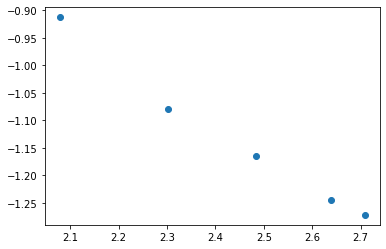

In [74]:
L=[15,14,12,10,8]

maxsv=[]
maxsus=[]
for k in range(nroFilesV):
    maxsv.append(PhiMean_V[k][10])
    maxsus.append(max(PhiVar_V[k]))
    


print(maxsv,maxsus)

plt.plot(np.log(L),np.log(maxsv), 'o')
plt.show()

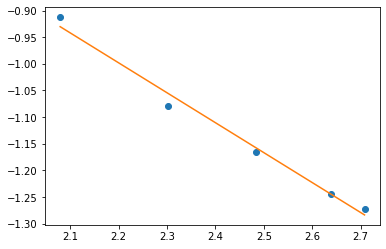

slope is -0.5623948859502426


In [75]:
plt.plot(np.log(L),np.log(maxsv), 'o')
m,b=np.polyfit(np.log(L),np.log(maxsv), 1)
plt.plot(np.log(L), m*np.log(L)+b)
plt.show()

print('slope is', m)

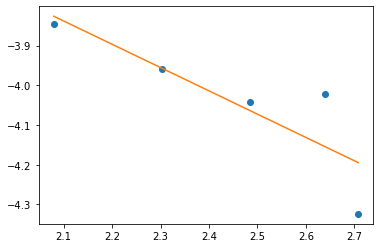

slope is -0.5860626186870009


In [76]:
plt.plot(np.log(L),np.log(maxsus), 'o')
m,b=np.polyfit(np.log(L),np.log(maxsus), 1)
plt.plot(np.log(L), m*np.log(L)+b)
plt.show()

print('slope is', m)